## Goal

1. Find relationship between runs scored (RS) and runs against (RA) to win percentage.

2. Possibly improve upon the well known [Pythagenpat](https://legacy.baseballprospectus.com/glossary/index.php?mode=viewstat&stat=136) formula




# Step 1

Obtain data from baseball reference

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

## Load and update team logs

In [2]:
def get_table(soup):
    data = []
    # Disclaimer: I used some of the code from pybaseball on github and modified the functions.
    table = soup.find_all('table', {'id': 'franchise_years'})[0]
    headings = [row.text.strip() for row in table.find_all('th')[0:21]]

    rows = table.find_all('tr')[1:] # [1:] to remove headings from rows
    for row in rows:
        year = row.find('th').text
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        cols.insert(0, year) # insert year at beginning of columns
        data.append([ele for ele in cols[0:]])
        
    data = pd.DataFrame(data=data, columns=headings)    

    return data

In [3]:
def player_batting_bref(team_id):
    # Disclaimer: I used some of the code from pybaseball on github and modified the functions.
    url = 'https://www.baseball-reference.com/teams/'+team_id +'/index.shtml'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    data = get_table(soup)
    
    return data

In [4]:
def give_me_df(team_ids):
    # Disclaimer: I used some of the code from pybaseball on github and modified the functions.
    master = pd.DataFrame()

    for team in team_ids:

        df= player_batting_bref(team_ids)
        master = master.append(df)

#        master['player_name'].fillna(player, inplace=True)
    
    master.reset_index(drop=True,inplace=True)
    
    return master

### I am scraping this web-page but for every team in the mlb.

In [5]:
url =  'https://www.baseball-reference.com/teams/TOR/index.shtml'
response = requests.get(url)
soup = BeautifulSoup(response.content,'html.parser')

In [6]:
teams = ['LAD','HOU','MIN','NYY','TBD','CHC','PHI','MIL','ATL','COL','TEX','BOS','STL','SDP','CLE','OAK'
    ,'ARI','CHW','ANA','PIT','NYM','CIN','WSN','SFG','DET','SEA','FLO','TOR'
        ,'BAL','KCR']

In [7]:
df1= pd.DataFrame()
for team in teams:
    try:
        df1 = df1.append(give_me_df(team))
        print('PASSED WITH TEAM :',team)
    except:
        print('FAILED WITH TEAM ',team)
        pass

PASSED WITH TEAM : LAD
PASSED WITH TEAM : HOU
PASSED WITH TEAM : MIN
PASSED WITH TEAM : NYY
PASSED WITH TEAM : TBD
PASSED WITH TEAM : CHC
PASSED WITH TEAM : PHI
PASSED WITH TEAM : MIL
PASSED WITH TEAM : ATL
PASSED WITH TEAM : COL
PASSED WITH TEAM : TEX
PASSED WITH TEAM : BOS
PASSED WITH TEAM : STL
PASSED WITH TEAM : SDP
PASSED WITH TEAM : CLE
PASSED WITH TEAM : OAK
PASSED WITH TEAM : ARI
PASSED WITH TEAM : CHW
PASSED WITH TEAM : ANA
PASSED WITH TEAM : PIT
PASSED WITH TEAM : NYM
PASSED WITH TEAM : CIN
PASSED WITH TEAM : WSN
PASSED WITH TEAM : SFG
PASSED WITH TEAM : DET
PASSED WITH TEAM : SEA
PASSED WITH TEAM : FLO
PASSED WITH TEAM : TOR
PASSED WITH TEAM : BAL
PASSED WITH TEAM : KCR


In [8]:
df1 = df1.drop_duplicates()

In [9]:
df1.columns

Index(['Year', 'Tm', 'Lg', 'G', 'W', 'L', 'Ties', 'W-L%', 'pythW-L%', 'Finish',
       'GB', 'Playoffs', 'R', 'RA', 'Attendance', 'BatAge', 'PAge', '#Bat',
       '#P', 'Top Player', 'Managers'],
      dtype='object')

In [10]:
df1.shape

(2684, 21)

In [11]:
df1 = df1[df1.Year!="2019"]

In [12]:
df1_reserve = df1.copy()

In [13]:
df1.drop_duplicates(subset=['R','RA'],inplace=True, keep='last')
#there were a few seasons where the Runs scored and Runs against were the exact same...
#I decided to drop these because that will prevent our neural network from overfitting since we will be using
#the Mean Squared Error

### Preview:

This is basically what was scrapped

In [14]:
df1_reserve.sample(3)

,Year,Tm,Lg,G,W,L,Ties,W-L%,pythW-L%,Finish,...,Playoffs,R,RA,Attendance,BatAge,PAge,#Bat,#P,Top Player,Managers
135,1884,Boston Beaneaters,NL,116,73,38,5,.658,.667,2nd of 8,...,,684,468,,27.0,24.1,17,5,C.Buffinton (16.3),J.Morrill (73-38)
54,1965,New York Yankees,AL,162,77,85,0,.475,.505,6th of 10,...,,611,604,"1,213,552",28.3,27.2,40,16,M.Stottlemyre (6.9),J.Keane (77-85)
17,2002,Texas Rangers,AL West,162,72,90,0,.444,.479,4th of 4,...,,843,882,"2,352,397",29.0,29.7,51,27,A.Rodriguez (8.8),J.Narron (72-90)


In [15]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [16]:
df1.R = df1.R.astype(int)
df1.RA = df1.RA.astype(int)
df1.G = df1.G.astype(int)
df1['W-L%'] = df1['W-L%'].astype(float)
df1['W-L%'] = df1['W-L%'] * 100

# Step 2: TEST TRAIN SPLIT

In [17]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
            df1[['R','RA','G']], df1['W-L%'], test_size=0.30, random_state=42)

## Step 3: running a few machine learning regression models

In [18]:
decision_tree = tree.DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators = 100, random_state= 0)
ada = AdaBoostRegressor(random_state =0)
LR = LinearRegression()

decision_tree.fit(x_train[['R','RA']], y_train)
rf.fit(x_train[['R','RA']],y_train)
ada.fit(x_train[['R','RA']],y_train)
LR.fit(x_train[['R','RA']],y_train)

dt_preds = decision_tree.predict(x_test[['R','RA']])
rf_preds = rf.predict(x_test[['R','RA']])
ada_preds = ada.predict(x_test[['R','RA']])
LR_preds = LR.predict(x_test[['R','RA']])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [19]:
mean_absolute_error(y_test, dt_preds), mean_absolute_error(y_test, rf_preds), mean_absolute_error(y_test, ada_preds), mean_absolute_error(y_test, LR_preds)

(3.1002531645569618, 2.3656974683544303, 2.790482213238844, 2.1654214519569748)

## Step 4: Comapring Mean Squared Error

MSE is better then mean absolute error. Take for example 2 points and a non-vertical line that seperates them. It won't matter if you move your line an inch above or below where it is... as long as it's in between the points the mean absolute error will stay the same (because it just calculates NET distance, so if one of the distances gets shorter but the other one gets longer it will come back to the same)... We need to do better which is why we use Mean Squared Error (MSE) MSE will penalize the points furter away so we will get 1 and only 1 solution which minimizes this.

In [20]:
mean_squared_error(y_test, dt_preds), mean_squared_error(y_test, rf_preds), mean_squared_error(y_test, ada_preds), mean_squared_error(y_test, LR_preds)

(15.260379746835444, 8.886065750632914, 12.491174785609724, 7.437530450772187)

### Getting the Error:

You can take the squared root of the MSE to get the error, here we notice that for Random Forest the error is 2.91% and for Linear regression (multiple linear regression) its 2.75% a pretty solid result

In [21]:
mean_squared_error(y_test, rf_preds)**0.5, mean_squared_error(y_test, LR_preds)**0.5 

(2.9809504777223177, 2.7271836114886336)

## Step 5 finding the MSE with the Pythagenport and Pythagenpat equations.

Pythagenpat is better then Pythagenport... lets confirm this


$$
X_{port} = \text{1.83  or 2.0} \\
\text{Win percentage} = \frac{r_s^{X_{port}}}{r_s^{X_{port}} + r_a^{X_{port}}}
$$

<br> Again we will iterate through a bunch of exponents and find the best one

### Pythagenport exploration

win % = rs ^ x / (rs ^ x + ra ^ x)   tested for run environments between 4 and 40
where X = 2 or 1.83

In [22]:
test_losses = pd.DataFrame()
row = 0
for power in range(1500,2500):
    test_losses.loc[row,'power'] = power
    test_losses.loc[row,'MSE'] = mean_squared_error(y_test, (x_test.R**(power/1000)/(x_test.R**(power/1000)+x_test.RA**(power/1000)))* 100)
    row += 1

In [23]:
train_losses = pd.DataFrame()
row = 0
for power in range(1500,2500):
    train_losses.loc[row,'power'] = power
    train_losses.loc[row,'MSE'] = mean_squared_error(y_train, (x_train.R**(power/1000)/(x_train.R**(power/1000)+x_train.RA**(power/1000)))* 100)
    row += 1

In [24]:
test_losses.loc[test_losses.MSE ==test_losses.MSE.min()]

,power,MSE
357,1857.0,6.623476


In [25]:
train_losses.loc[train_losses.MSE ==train_losses.MSE.min()]

,power,MSE
349,1849.0,7.117114


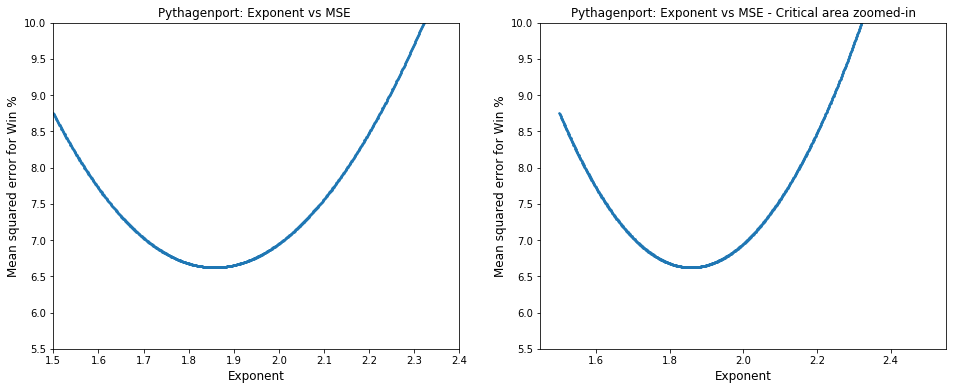

In [26]:
fig = plt.figure(figsize = [16,6])

plt.subplot(1,2,2)
# plt.figure(figsize=(7,4.5))
plt.scatter(test_losses.power/1000, test_losses.MSE, s=2.5)
plt.xlabel('Exponent', fontsize= 12)
plt.ylabel('Mean squared error for Win %', fontsize= 12)
# plt.xticks(np.arange(0,0.45,0.04))
# plt.xlim(1.7,2.1)
# plt.yscale(value='log')
plt.ylim(5.5,10)
plt.title('Pythagenport: Exponent vs MSE - Critical area zoomed-in')



plt.subplot(1,2,1)
# plt.figure(figsize=(7,4.5))
plt.scatter(test_losses.power/1000, test_losses.MSE, s=2.5)
plt.xlabel('Exponent', fontsize = 12)
plt.ylabel('Mean squared error for Win %', fontsize = 12)
plt.xlim(1.5,2.4)
plt.ylim(5.5,10)
plt.title('Pythagenport: Exponent vs MSE ');



In [27]:
test_losses.query('power == 2000')

,power,MSE
500,2000.0,6.950641


### Pythagenport results:

As expected, the pythagenport MSE is better then the Multiple Linear regression but slightly higher then Pythagenpart. 

### Pythagenpat exploration


$$
X_{pat} = \left(\frac{r_a + r_s}{\text{Number of games}}\right)^{\text{exponent}} \\
\text{Win percentage} = \frac{r_s^{X_{pat}}}{r_s^{X_{pat}} + r_a^{X_{pat}}}
$$

Lets iterate through all the decimals and find the best exponent for our test set

In [28]:
Train_losses = pd.DataFrame()
row = 0
for i in range(100,950):
    x_train['X_pyth'] = ((x_train.R + x_train.RA)/x_train.G)**(i/1000)
    x_train['W%_pyth'] = (x_train.R**x_train.X_pyth) / ( x_train.R**x_train.X_pyth + x_train.RA**x_train.X_pyth)
    Train_losses.loc[row,'i_exponent'] = i
    Train_losses.loc[row,'MSE'] = mean_squared_error(y_train, x_train['W%_pyth']*100)
    row = row + 1

In [29]:
Test_losses = pd.DataFrame()
row = 0
for i in range(100,950):
    x_test['X_pyth'] = ((x_test.R + x_test.RA)/x_test.G)**(i/1000)
    x_test['W%_pyth'] = (x_test.R**x_test.X_pyth) / ( x_test.R**x_test.X_pyth + x_test.RA**x_test.X_pyth)
    Test_losses.loc[row,'i_exponent'] = i
    Test_losses.loc[row,'MSE'] = mean_squared_error(y_test, x_test['W%_pyth']*100)
    row = row + 1

In [30]:
Train_losses[Train_losses.MSE==Train_losses.MSE.min()]

,i_exponent,MSE
180,280.0,7.024007


In [31]:
Test_losses[Test_losses.MSE==Test_losses.MSE.min()]

,i_exponent,MSE
184,284.0,6.590053


In [32]:
Test_losses.MSE.min()**0.5

2.567109937116124

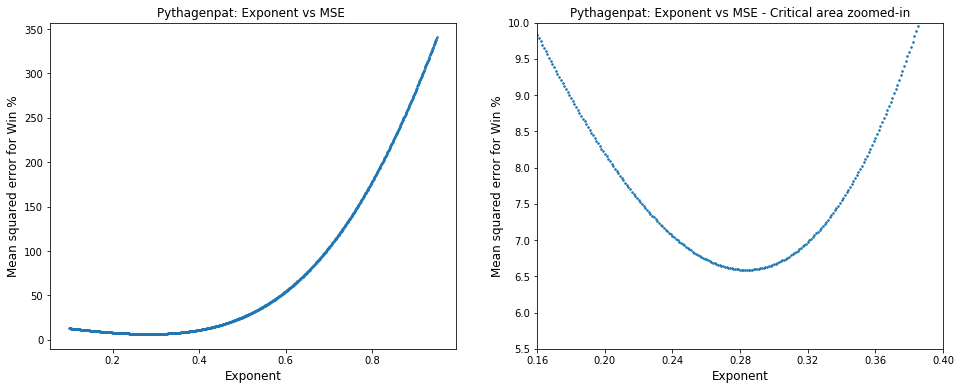

In [33]:
fig = plt.figure(figsize = [16,6])

plt.subplot(1,2,2)
# plt.figure(figsize=(7,4.5))
plt.scatter(Test_losses.i_exponent/1000, Test_losses.MSE, s=2.5)
plt.xlabel('Exponent', fontsize= 12)
plt.ylabel('Mean squared error for Win %', fontsize= 12)
plt.xticks(np.arange(0,0.45,0.04))
plt.xlim(0.16,0.4)
# plt.yscale(value='log')
plt.ylim(5.5,10)
plt.title('Pythagenpat: Exponent vs MSE - Critical area zoomed-in')



plt.subplot(1,2,1)
# plt.figure(figsize=(7,4.5))
plt.scatter(Test_losses.i_exponent/1000, Test_losses.MSE, s=2.5)
plt.xlabel('Exponent', fontsize = 12)
plt.ylabel('Mean squared error for Win %', fontsize = 12)
plt.title('Pythagenpat: Exponent vs MSE ');


### Pythagenpat results:

As we can see, the MSE is 6.59 which is better then our Multiple Linear Regression. Grabbing the square root gets us 2.567%

## Conclusion so far:

Yes, this is consistent with the current litterature... Pythagenpat is the best formula/function to predict Win %. We can see the root mean squared error is 6.59 vs 6.62 for PythagenPort. With lienar regression, we were only able to obtain a MSE of 7.5. Other standard machine learning models all had MSE greater then 7.5, all this means is that Pythagenpat is the best estimator we have so far.

Pythagenpat: https://legacy.baseballprospectus.com/glossary/index.php?mode=viewstat&stat=136
<br>Pythagenport: https://legacy.baseballprospectus.com/glossary/index.php?search=pythagenport

## Part 6: grid search on RandomForest to see if we can improve it 

In [34]:
%%time
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV

#the best model was the Random Forest Classifier

# TODO: Initialize the classifier
clf = RandomForestRegressor(n_estimators= 100,random_state = 0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = { 'n_estimators': [100,200], 
              'min_samples_split' : [2,10,20], 
              'min_samples_leaf' :  [2,10,20],
              }

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring='neg_mean_squared_error', cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train[['R','RA']], y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train[['R','RA']], y_train)).predict(x_test[['R','RA']])
best_predictions = best_clf.predict(x_test[['R','RA']])

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("MSE score on testing data: {:.7f}".format(mean_squared_error(y_test, predictions)))
print("\nOptimized Model\n------")
print("MSE score on the testing data: {:.7f}".format(mean_squared_error(y_test, best_predictions)))
print(best_clf)

Unoptimized model
------
MSE score on testing data: 8.8860658

Optimized Model
------
MSE score on the testing data: 8.2038109
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
Wall time: 23.4 s


### Results:
MSE on optimized model is still higher then LR and obviously higher then Pythagenpat

## Step 7: Transform our data using sklearn's StandardScaler, re-run basic ML algorithms

In [35]:
from sklearn.preprocessing import StandardScaler

new_df =pd.DataFrame()
scaler = StandardScaler()
scaler.fit(df1[['R','RA']])

col_to_trsf= ['R','RA']
new_df = df1[['R','RA','W-L%']].copy()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [36]:
new_x_train = scaler.transform(x_train[['R','RA']])
new_x_test  = scaler.transform(x_test[['R','RA']])
new_y_train = y_train.to_frame()/100
new_y_test = y_test.to_frame()/100

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  


## Re-do basic ML models from above

In [37]:
x_train.shape, new_x_train.shape

((1841, 5), (1841, 2))

In [38]:
decision_tree = tree.DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators = 100, random_state= 0)
ada = AdaBoostRegressor(random_state =0)
LR = LinearRegression()

decision_tree.fit(new_x_train, new_y_train)
rf.fit(new_x_train,new_y_train)
ada.fit(new_x_train,new_y_train)
LR.fit(new_x_train,new_y_train)

dt_preds = decision_tree.predict(new_x_test)
rf_preds = rf.predict(new_x_test)
ada_preds = ada.predict(new_x_test)
LR_preds = LR.predict(new_x_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
mean_squared_error(new_y_test, dt_preds), mean_squared_error(new_y_test, rf_preds), mean_squared_error(new_y_test, ada_preds), mean_squared_error(new_y_test, LR_preds)

(0.0014780721518987342,
 0.0008850011169620252,
 0.0012640692447117338,
 0.0007437530450772191)

In [40]:
mean_squared_error(new_y_test, rf_preds)**0.5, mean_squared_error(new_y_test, LR_preds)**0.5 

(0.02974896833441498, 0.027271836114886344)

In [41]:
%%time
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV

#the best model was the Random Forest Classifier

# TODO: Initialize the classifier
clf = RandomForestRegressor(n_estimators= 100,random_state = 0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = { 'n_estimators': [100,200], 
              'min_samples_split' : [2,10,20], 
              'min_samples_leaf' :  [2,10,20],
              }

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring='neg_mean_squared_error', cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(new_x_train, new_y_train['W-L%'])

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(new_x_train, new_y_train)).predict(new_x_test)
best_predictions = best_clf.predict(new_x_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("MSE score on testing data: {:.7f}".format(mean_squared_error(new_y_test['W-L%'], predictions)))
print("\nOptimized Model\n------")
print("MSE score on the testing data: {:.7f}".format(mean_squared_error(new_y_test['W-L%'], best_predictions)))
print(best_clf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Unoptimized model
------
MSE score on testing data: 0.0008850

Optimized Model
------
MSE score on the testing data: 0.0008202
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
Wall time: 23.2 s


### Same result as above

using grid search on Random Forest didn't improve the results.

## Step 7: Running a quick Neural Network

### importing the proper libraries for PyTorch

In [42]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cpu':
    torch.cuda.get_device_name()

### Creating my neural net:

the last hidden layer has a Sigmoid function which bounds the result from 0-1 which is why I wanted my win% in y_train and y_test to be between 0-1

In [44]:
class model_classifier(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output = 1):
        super().__init__()
        self.fc1 = nn.Linear(n_feature, n_hidden) 
        self.fc2 = nn.Linear(n_hidden, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, n_output)
        
        self.dropout = nn.Dropout(p=0)
        
    def forward(self, x):
                
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [45]:
model = model_classifier(n_feature = new_x_train.shape[1], n_hidden = 60, n_output = 1)

optimizer = optim.Adam(model.parameters(), lr = 0.00001)

criterion = nn.MSELoss()

model.to(device);

In [46]:
epochs = 30000
model.to(device);
from tqdm import tqdm_notebook as tqdm

x_train_tensor = torch.tensor(new_x_train).float().to(device)
y_train_tensor = torch.tensor(new_y_train.values).float().to(device)

x_test_tensor = torch.tensor(new_x_test).float().to(device)
y_test_tensor = torch.tensor(new_y_test.values).float().to(device)

train_loss_records, test_loss_records = [], []
model.train()
for epoch in tqdm(range(0,epochs)):
    running_loss = 0
    
    optimizer.zero_grad()
    
    output = model(x_train_tensor)
    y_train_tensor =  y_train_tensor.view(*output.shape)
    loss = criterion(output,y_train_tensor)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    train_loss_records.append(running_loss)
    
    model.eval()
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
        
        output2 = model(x_test_tensor)
        y_test_tensor = y_test_tensor.view(*output2.shape)
        test_loss += criterion(output2, y_test_tensor)
        
        test_loss_records.append(test_loss.item()) 
    
    if epoch%1000==0:
        state = {
            'epoch': epoch, # done
             'state_dict': model.state_dict(),    #done
             'optimizer':optimizer.state_dict(),  #done
             'hidden_units': 60,        #saved for loading purposes
             'input_units': new_x_train.shape[1], 
             'output': 1
                }
    
        filepath = 'saved_models/final_model'+str(epoch) +'.pth'
        torch.save(state, filepath)
    
    model.train()


In [47]:
tls = pd.DataFrame(train_loss_records)
tls.rename(columns={0:'MSE'}, inplace=True)
testlr = pd.DataFrame(test_loss_records)
testlr.rename(columns={0:'MSE'}, inplace=True)

### Neural Net results

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)


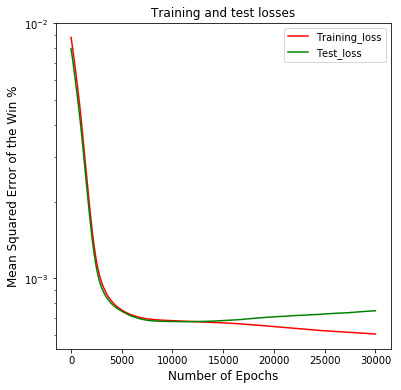

In [48]:
plt.figure(figsize=[6,6])
plt.plot(tls, label='Training_loss', color='r')
plt.plot(testlr, label='Test_loss', color='g')
plt.legend()
plt.yscale('log')
plt.title("Training and test losses", fontsize = 12)
plt.xlabel("Number of Epochs", fontsize = 12)
plt.ylabel('Mean Squared Error of the Win %', fontsize = 12)
print(optimizer)

#### Zoomed in graph at the part where the lines diverge

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)


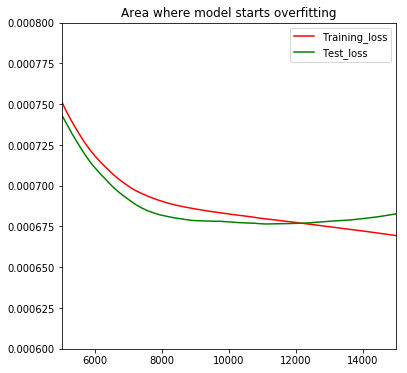

In [85]:
plt.figure(figsize=[6,6])
plt.plot(tls, label='Training_loss', color='r')
plt.plot(testlr, label='Test_loss', color='g')
print(optimizer)
plt.xlim(5000,15000)
plt.ylim(0.0006,0.0008)
plt.legend()
plt.title('Area where model starts overfitting');

In [50]:
testlr.tail()  #stands for test losses, this gets me the last 5 values at the end...

,MSE
29995,0.000746
29996,0.000746
29997,0.000747
29998,0.000746
29999,0.000746


## Need to get .000683 or lower

In [51]:
testlr[testlr.MSE == testlr.MSE.min()]

,MSE
11172,0.000677


In [52]:
# train error at lowest test error iteration
tls.loc[testlr[testlr.MSE == testlr.MSE.min()].index]

,MSE
11172,0.000679


In [86]:
# last 5 training_losses recorded.. clear overfitting as expected 
tls.tail()

,MSE
29995,0.000606
29996,0.000606
29997,0.000606
29998,0.000606
29999,0.000606


### Conclusion: 

After running our neural network, we got very similar values as our Pythagenpat which had a MSE of 6.59 . In order to do this we had to follow the standard ML protocol of Standardized our inputs and ouputs. In this case I didn't have to standardize the output.

Now we basically have a model and we can input the Runs Scored and Runs Against and obtain a very accurate Win % estimator.

The reason we obtain errors is that the amount of wins and losses isn't 100% related to the amount of runs scored and runs against, for example consider a team winning 13-0 and losing the next game 0-1... now repeat these games multiple times and the team would have scored 13\*n runs and would have allowed 1\*n... their record would be 50% yet the Pythagenpat and our neural net model would surely predict a very high win-rate... 

So yes, runs scored and runs against is not a perfect model but having an error of 2.59% is pretty good. So, assuming our results follow a normal distribution, 66% of the time the error will be +-2.55%, 95% it will be +-5% and 99.9% of the time it will be at +-7.5%. 2.5% translates to 4 games which means that 99.9% of the time the team's actual amount of wins will vary by 12 games on the upside or 12 games on the downside.z

In [87]:
state = torch.load('saved_models/final_model11000.pth')

In [88]:
state['hidden_units']

60

In [89]:
model2 = model_classifier(n_hidden = state['hidden_units'], n_feature = state['input_units'])

In [90]:
model2.load_state_dict(state['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Visualizing the results

Here we attempt to visualize the results of the 3 models. We begin with the Pythagenpat model where we keep the number of games constant at 160.


We consider total scores between 0 and 1000 per season.

In [91]:
sample_set = df1[['R','RA','W-L%']]
x = sample_set['R']
y = sample_set['RA']

In [92]:
sample_set.shape

(2631, 3)

### Original Results

Text(0.5, 1.0, 'Runs Scored vs Runs Against for all current MLB franchises')

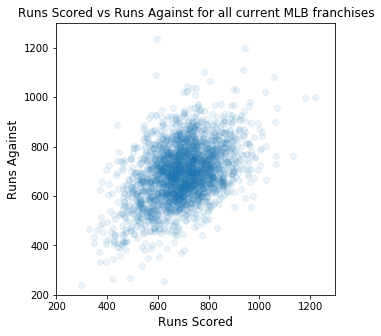

In [93]:
plt.figure(figsize=[5,5])
sb.regplot(data=sample_set, x='R', y='RA', scatter_kws ={'alpha':1/12}, fit_reg = False,ci=None)
plt.xlim(200,1300)
plt.ylim(200,1300)
plt.xlabel('Runs Scored', fontsize= 12)
plt.ylabel('Runs Against', fontsize = 12)
plt.title('Runs Scored vs Runs Against for all current MLB franchises', fontsize = 12)

In [94]:
import matplotlib

(200, 1300)

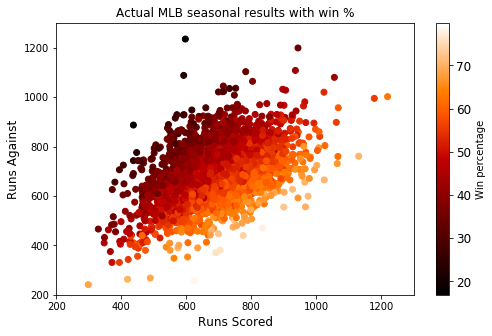

In [95]:
plt.figure(figsize=[8,5])
# normalize = matplotlib.colors.Normalize(vmin=-1, vmax=1,)

# plt.style.use('seaborn-darkgrid')
plt.scatter(data=sample_set, x='R', y='RA', c= 'W-L%', cmap='gist_heat')  #viridis RdBu   #seismic
cbar = plt.colorbar(label='Win percentage')
cbar.ax.tick_params(labelsize=12)

# cbar.set_ticks(np.arange(0.2,0.8,0.1))
# cbar.set_ticklabels(np.arange(0.2,0.8,0.1))

plt.xlabel('Runs Scored', fontsize=12)
plt.ylabel('Runs Against', fontsize= 12)
plt.title('Actual MLB seasonal results with win %')
plt.xlim(200,1300)
plt.ylim(200,1300)

In [96]:
runs_for = np.arange(1400).reshape(1, -1)
runs_against = np.arange(1400).reshape(-1, 1)

In [97]:
# pythagenport
runs_for_mesh, runs_against_mesh = np.meshgrid(runs_for, runs_against)
exponent = 1.857
# X_pyth = ((runs_for + runs_against) / 160) ** exponent
win_percentage = ((runs_for_mesh**exponent) / 
                  (runs_for_mesh**exponent + runs_against_mesh**exponent))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'Pythagenport Win % predictions')

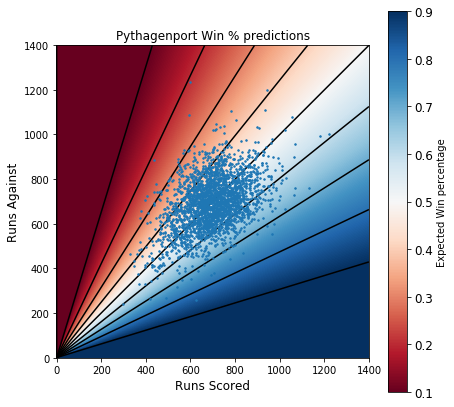

In [98]:
# Here I chose a diverging colormap, RdBu (Red Blue)
# Where white describes a 0.500 record
plt.figure(figsize=[7,7])
plt.imshow(win_percentage, vmin=0.1, vmax=0.9, origin='lower', cmap='RdBu')  #RdBu
cbar = plt.colorbar(label='Expected Win percentage')
cbar.ax.tick_params(labelsize=12)
plt.contour(win_percentage, origin='lower', levels=10, colors=['#000000'] * 20)

plt.plot(x,y, marker='o', markersize=1.5, linestyle='None')

plt.xlabel('Runs Scored', fontsize= 12)
plt.ylabel('Runs Against', fontsize= 12)
plt.title('Pythagenport Win % predictions', fontsize =12)



Text(0.5, 1.0, 'Pythagenport Win % predictions, main area')

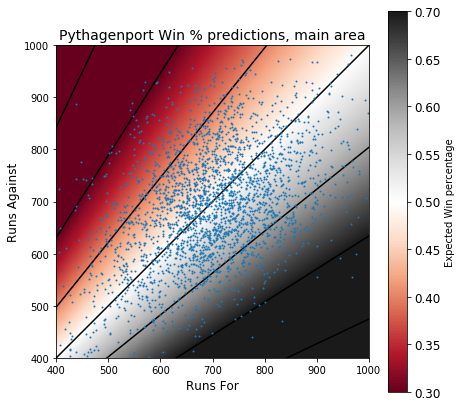

In [99]:
plt.figure(figsize=[7,7])
plt.imshow(win_percentage, vmin=0.3, vmax=0.7, origin='lower', cmap='RdGy')
cbar = plt.colorbar(label='Expected Win percentage')
cbar.ax.tick_params(labelsize=12)
plt.contour(win_percentage, origin='lower', levels=10, colors=['#000000'] * 20)
plt.plot(x,y, marker='o',markersize=1, linestyle='None')
plt.xlim(400,1000)
plt.ylim(400,1000)

plt.xlabel('Runs For', fontsize= 12)
plt.ylabel('Runs Against', fontsize= 12)
plt.title('Pythagenport Win % predictions, main area', fontsize= 14)

The Pythogenpat model estimates the exponent as

$$
X_{pyth} = \left(\frac{r_a + r_s}{\text{Number of games}}\right)^{\text{exponent}} \\
\text{Win percentage} = \frac{r_s^{X_{pyth}}}{r_s^{X_{pyth}} + r_a^{X_{pyth}}}
$$

In [100]:
runs_for_mesh, runs_against_mesh = np.meshgrid(runs_for, runs_against)
exponent = 0.284
X_pyth = ((runs_for + runs_against) / 162) ** exponent
win_percentage = ((runs_for_mesh**X_pyth) / 
                  (runs_for_mesh**X_pyth + runs_against_mesh**X_pyth))

In [101]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Pythogenpat prediction')

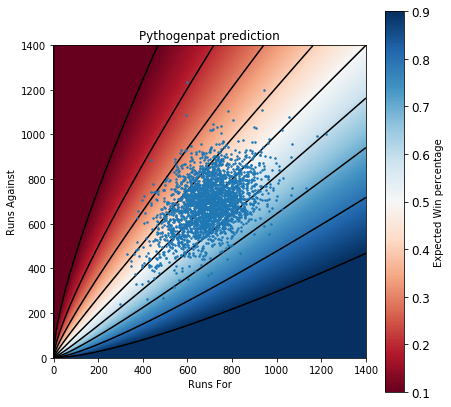

In [102]:
# Here I chose a diverging colormap, RdBu (Red Blue)
# Where white describes a 0.500 record
plt.figure(figsize=[7,7])
plt.imshow(win_percentage, vmin=0.1, vmax=0.9, origin='lower', cmap='RdBu')  #RdBu
cbar = plt.colorbar(label='Expected Win percentage')
cbar.ax.tick_params(labelsize=12)
plt.contour(win_percentage, origin='lower', levels=10, colors=['#000000'] * 20)
plt.plot(x,y, marker='o', markersize=1.5, linestyle='None')

plt.xlabel('Runs For')
plt.ylabel('Runs Against')
plt.title('Pythogenpat prediction')

Here we can see a smooth transition, from the case where a team has an equal number of runs scored, and runs against. In that case, the Pythogenpat model predicts that the team won 50% of its games. As the statistics change, the Pythogenpat model smoothly transitions to estimating that the team always won.

In [103]:
runs_for_trs = (runs_for - scaler.mean_[0]) / scaler.scale_[0]
runs_against_trs = (runs_against - scaler.mean_[1]) / scaler.scale_[1]

In [104]:
# Runs = scaler.transform(combined)
for_mesh, against_mesh = np.meshgrid(runs_for_trs, runs_against_trs)

In [105]:
input_tensor = np.concatenate([for_mesh.reshape(-1, 1), against_mesh.reshape(-1, 1)], axis=1)

In [106]:
input_tensor

array([[-6.12891919, -6.00960231],
       [-6.12010617, -6.00960231],
       [-6.11129315, -6.00960231],
       ...,
       [ 6.18286584,  6.13290549],
       [ 6.19167886,  6.13290549],
       [ 6.20049188,  6.13290549]])

In [107]:
torch.cuda.empty_cache()

In [108]:
model2.to('cpu')

model_classifier(
  (fc1): Linear(in_features=2, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=15, bias=True)
  (fc4): Linear(in_features=15, out_features=1, bias=True)
  (dropout): Dropout(p=0)
)

In [109]:
results = model2(torch.tensor(input_tensor).float())

In [110]:
results = results.detach().to('cpu').numpy()

In [111]:
results = results.reshape(runs_against.size, runs_for.size)

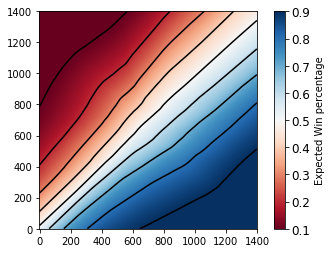

In [113]:
plt.contour(results, origin='lower', levels=10, colors=['#000000'] * 20)
plt.imshow(results, vmin=0.1, vmax=0.9, origin='lower', cmap='RdBu')
cbar = plt.colorbar(label='Expected Win percentage')
cbar.ax.tick_params(labelsize=12)

Text(0.5, 1.0, 'Neural network Win % predictions')

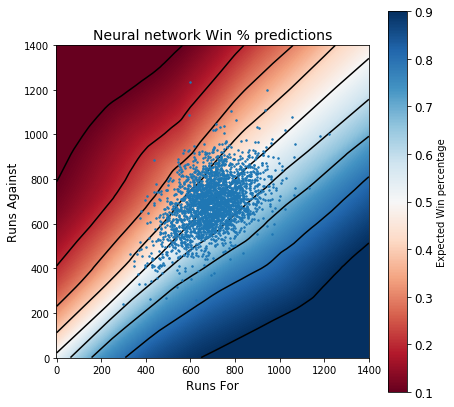

In [114]:
plt.figure(figsize=[7,7])
plt.imshow(results, vmin=0.1, vmax=0.9, origin='lower', cmap='RdBu')
cbar = plt.colorbar(label='Expected Win percentage')
cbar.ax.tick_params(labelsize=12)
# plt.contour(results, origin='lower', levels=10, colors=['#000000'] * 20)
contours = plt.contour(results, origin='lower', levels=10, colors=['#000000'] * 20)
# plt.gca().clabel(contours, contours.levels[4:7], inline=True, fontsize=10, use_clabeltext=True)
plt.plot(x,y, marker='o',markersize=1.5, linestyle='None')

plt.xlabel('Runs For', fontsize= 12)
plt.ylabel('Runs Against', fontsize= 12)
plt.title('Neural network Win % predictions', fontsize= 14)

Text(0.5, 1.0, 'Neural network Win % predictions, main area')

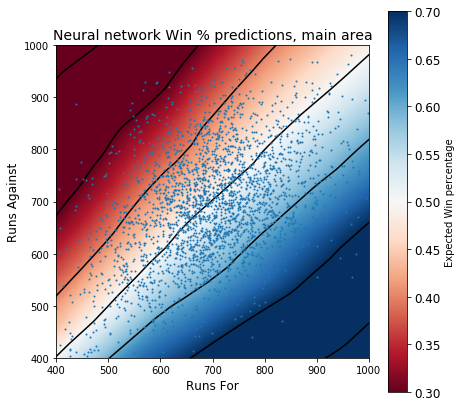

In [115]:
plt.figure(figsize=[7,7])
plt.imshow(results, vmin=0.3, vmax=0.7, origin='lower', cmap='RdBu')
cbar = plt.colorbar(label='Expected Win percentage')
cbar.ax.tick_params(labelsize=12)
plt.contour(results, origin='lower', levels=10, colors=['#000000'] * 20)
plt.plot(x,y, marker='o',markersize=1, linestyle='None')
plt.xlim(400,1000)
plt.ylim(400,1000)

plt.xlabel('Runs For', fontsize= 12)
plt.ylabel('Runs Against', fontsize= 12)
plt.title('Neural network Win % predictions, main area', fontsize= 14)